#Intro

My name is Lior and I am a Data Engineer\Backend Engineer and Computer Science student. 
As a data engineer, I am familiar with data architectures, pipeline, transformation, cleaning, etc.

This course is an opportunity for me to dive into the data science world and become more familiar with other parts of the "data cycle" - feature engineering, predictive modelling and data visualizations.

Moreover, Natural language processing (**NLP**) is a field I wanted to learn since I was in a lecture last year.
When I found the Kaggle challenge I thought this is a great opportunity for me.
The challenge's goal is to build a model that can look at the labelled sentiment for a given tweet and figure out what word or phrase best supports it.


#Sentiment Analysis & Keyword Extraction

**Sentiment Analysis** - A tool to automatically monitor emotions in conversations - it can be on social media platforms, products reviews, chatbots. 

Sentiment analysis is done with NLP.
NLP is a field that focuses on making natural human language usable by computer programs. 

Some examples of NLP implementations are -
Search engines like Google, Speech engines like Siri, social websites feed like the Facebook news feed, Spam filters, and more.
All of these algorithms understand your interests - each one for its own goal.

From wikipwedia: 

> *Sentiment analysis (also known as opinion mining or emotion AI) is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.*

**Keyword extraction** is a text analysis technique to extracts the most important words and phrases from a text. 
It helps summarize long content to a few words and phrases, to recognize the main topics discussed in a text.

Keyword extraction is being done with machine learning techniques in NLP.
We can use it to find keywords from all manner of text: academic articles, business reports, social media comments, forums messages and reviews, news reports, and more.

Imagine you want to analyze thousands of online reviews about your product, and ask questions such as: How many negative reviews relate to delivery time? How many reviews are talking about product quality?
Keyword extraction helps you sift through the whole set of data and obtain the words that best describe each review in just seconds, tagging the reviews.
With that, you can easily and automatically see what your customers are mentioning most often, make data-driven decisions and saving time for manual processing.

When extracting the main phrases, we are minimizing long text to few words, which makes it easy to understand what the long text is about.
With that, we can generate tags, indexing and summarized text.

# The challenge
https://www.kaggle.com/c/tweet-sentiment-extraction/overview

The challenge and this project are handling social media data.
Our goal is Look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.

# Intro to the "Twitter Culture"
**Tweets** are not written properly. They are very noisy and significant work has to be done to clean, analyze, and make them meaningful to use. Example from the dataset will be the best to understand:

>so i got to my exam centre n they said we can`t let u becuz of your sleeveless top! U cud BELIEVE that!? i had to go home

Analyzing this tweet from a human point of view - 

1.  Translating to English - ```n = and, u/U- you, becuz = because, cud= could```
2. centre-> center. This one seems to be a typo.
3. we have here `!?` and `BELIEVE` is capitalised - which empowers the anger of the writer.
4. `You Could believe that!?` it's not a proper way to ask a question in English. It should be written as - `Could you believe that?`

We can understand this tweet is negative, and I would extract ``we can`t let u`` or `U cud BELIEVE` to best support it.

OK, so we can understand tweets are a mess. They are not the same as documents, 
or customer reviews - But Y!?! 

Partly, it is because tweets need to be short. How short? 
**tweets have a limit of 280 characters**

this rule effect is that a long text will be shared as comments ("thread"), But mainly that most of the tweets are short.

Other than that, we have hash tagging (#), @ing (@) , and the desire to stand out with capital LETTERS, emojis 🥑👑, and other marks ?!@#$%.



After understaing this, I am starting with imports and loading the challenge data:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords 
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/test.csv")
train_df = train_df.dropna()
all_df = pd.concat([train_df, test_df], ignore_index=True)
train_df, val_df = train_test_split(train_df, train_size = 0.80, random_state = 1)

Fisrt, let's look on the data-

In [4]:
all_df.head(10)

textID  ... sentiment
0  cb774db0d1  ...   neutral
1  549e992a42  ...  negative
2  088c60f138  ...  negative
3  9642c003ef  ...  negative
4  358bd9e861  ...  negative
5  28b57f3990  ...   neutral
6  6e0c6d75b1  ...  positive
7  50e14c0bb8  ...   neutral
8  e050245fbd  ...   neutral
9  fc2cbefa9d  ...  positive

[10 rows x 4 columns]

The columns of the dataframe:

*  **textID** - Each row had an id
*  **text** - The tweet itself
* **selected_text** - The keywords extracted. For the train data set, we have information in the column, and in the test dataset, we don't have that information. Our goal is to generate this column for the test dataset. We can see the text here is with signs, URLs, punctuations, and not very "clean".
* **sentiment**- The text's sentiment. Can be neutral/positive/negative.


# EDA



### Data Distribution

I want to see tags distribution; how many positive/netural/negatives tweets we have in the datasets.

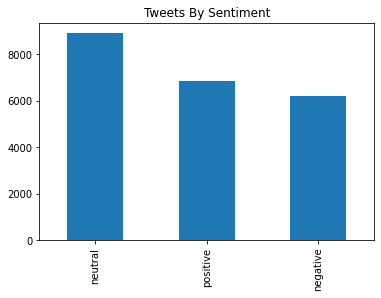

In [5]:
train_df['sentiment'].value_counts().plot.bar(title='Tweets By Sentiment') 

Seems we have 12K of netural tweets, 10K of positive twees and 9K of negative tweets. This is a good overall balance, and this is a basic check- If we would have tons of negative data but minority of positive data, keyword extraction of negative tweets was with better score the from the positive tweets. 

### Text cleaning

Tweets are very "dirty". They have lower and upper letters mixed, many signs, and URLs. Let's look about the dirty tweets, to learn about what we are dealing with.

In [6]:
# Find URLs tweets
pd.options.display.max_colwidth = 100
print ("Total " + str(all_df[all_df['text'].str.contains('http://')][['text']].count()))
all_df[all_df['text'].str.contains('http://')][['text']].head(5)

Total text    1394
dtype: int64


text
5          http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
17  i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on i...
35                 Thats it, its the end. Tears for Fears vs Eric Prydz, DJ Hero   http://bit.ly/2Hpbg4
50    Then you should check out http://twittersucks.com and connect with other tweeple who hate twitter
57                                                        will be back later.  http://plurk.com/p/rp3k7

In [7]:
# Find uppercase and signs tweets
print("Total " + str(all_df[all_df['text'].str.findall('[^a-z .,]').str.len()>15]['text'].count()))
all_df[all_df['text'].str.findall('[^a-z .,]').str.len()>15][['text']].head(5)

Total 1457


text
24                      SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cALLed LoSe f0LloWeRs FridAy... smH
43  RATT ROCKED NASHVILLE TONITE..ONE THING SUCKED, NO ENCORE!  LIKE IN THE 80`S THEY STILL HAVE A F...
46            egh blah and boooooooooooo i dunno wanna go to work  HANGOVERS SUCKKKKKK Im a drunk mess!
76                                                   WOW, i AM REALLY MiSSiN THE FAM(iLY) TODAY. BADDD.
80                                                                      THANK YYYYYYYYYOOOOOOOOOOUUUUU!

We have **1394** rows contain "http://". 
This makes sense since people are sharing websites, articles, and the latest news.

We have **1457** rows with more than 15 characters which are non-lowercased, space, or punctuation (,.).
Some of those tweets are written in understandable language - 

> `SEe waT I Mean bOuT FoLL0w fRiiDaYs... ItS cALLed LoSe f0LloWeRs FridAy... smH`

It took me more than 30 seconds to understand what is written here, but there are only 13 words. 
Those tweets emphasise the "Twitter Culture" we talked about in the intro.
Can't wait to see how our models will deal with those tweets, but for now- let's continue with the EDA.

For our EDA- we want to analyze the text without URLs and signs. Our cleaning function will lower all text, remove non-letters and URLs since the main goal of the EDA is to understand the common words used in tweets by sentiment.
For that, the clean helps us to "normalize" the text and to get a better understanding of keywords by sentiment.

However, in our model - it's important to not lose that data. 
For the Modeling, the cleaning will be minimalistic, since the selected_text column has "uncleaned" text- It has capital letters, URLs and non alpha-numeric text such as- !@$#.


In [8]:
URL = r'https?://\S+|www\.\S+'

def clean_text(txt: str):
  txt = str(txt).lower()
  # Remove URL
  txt = re.sub(URL, '', txt)
  # Remove signs
  txt = re.sub('[^a-z ]', ' ', txt)
  
  return txt

all_df['cleaned_text'] = all_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)

### Tokenization

**Word tokenization** breaks text down into individual words.
There is also sentence tokenization, that breaks text down into individual sentences.

Tokenization is one of  the first step in any NLP pipeline and has an important effect. This is the process of breaking down chunks of text into smaller pieces, that can be considered as discrete elements. This turns an unstructured string into a numerical data structure suitable for machine learning. 

Tokenization can separate sentences, words, characters, or subwords.
For the EDA, we want to split the text into individual words, word tokenization.

The following code is creating a bucket of words to each sentiment, with counter to each word in the bucket. Notice I remove english languge stop words.

In [9]:
stop_words = set(stopwords.words('english')) 

all_df['word_list'] = all_df['cleaned_text'].apply(lambda x: x.split())
train_df['word_list'] = train_df['cleaned_text'].apply(lambda x: x.split())

positives = all_df.where(all_df['sentiment'] == 'positive').dropna()
negatives = all_df.where(all_df['sentiment'] == 'negative').dropna()
neutrals = all_df.where(all_df['sentiment'] == 'neutral').dropna()

def word_count(series):
    word_dict = {}
    for wl in series:
      for w in wl:
          if w not in stop_words:
            word_dict[w] = word_dict.get(w,0)+1
    return word_dict

word_list_dict = {
    'Positives' : word_count(positives['word_list']),
    'Negatives' : word_count(negatives['word_list']),
    'Neutrals' : word_count(neutrals['word_list'])
}

We have the words tokenzied with the number of occurrences of a word. We can build a word cloud and look at the most popular words. 

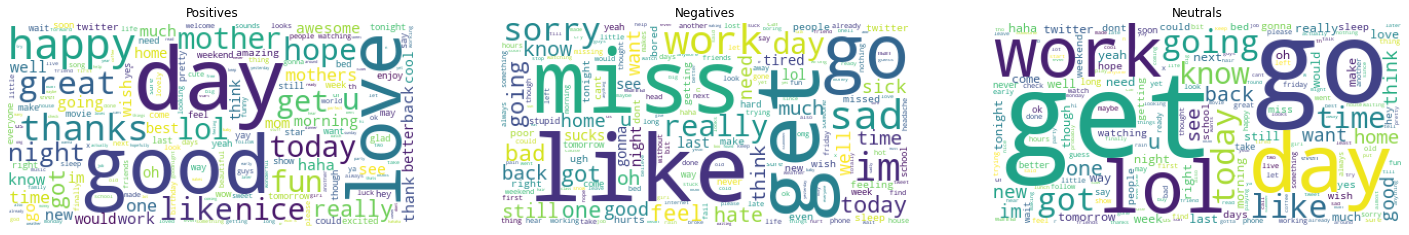

In [10]:
fig, axs = plt.subplots(1,3, figsize=(25 ,25))
count = 0
word_cloud_dict = {}
for key, value in word_list_dict.items():
  word_cloud_dict[key] = WordCloud(background_color ='white', collocations=False)
  word_cloud_dict[key].generate_from_frequencies(value)
  axs[count].set_title(key)
  axs[count].imshow(word_cloud_dict[key])
  axs[count].axis("off")
  count += 1

plt.show()

The word clouds can help us to understand the possible keywords to each sentiment in the tweets.

We can recognize **positive** words in the positive cloud such as good, love, happy, thanks. 

For the **negative** cloud - miss, sad, sorry. 

There are some **anomalies** as well:

*   The word "day" seems to be popular in both positive and neutrals tweets.
*   The word "like" seems to be very popular in the negative tweets, which is not what we would expect.
An explaination for that can be that meaning of the word "like" in those tweets is not "to feel attraction" and more "as if" meaning, such as in the following sentence- "hurts **like** crazy"
*   "go" apears to be popular on both negative & neutrals tweets.


Also, we can recognize "**Twitter words**" such- lol, U, haha.

### Words Statistics

After looking on the word clouds, we can add words numerical features to the- avg word length, number of words.

In [11]:
all_df['text_len'] = all_df['cleaned_text'].astype(str).apply(len)
all_df['text_word_count'] = all_df['cleaned_text'].apply(lambda x: len(str(x).split()))

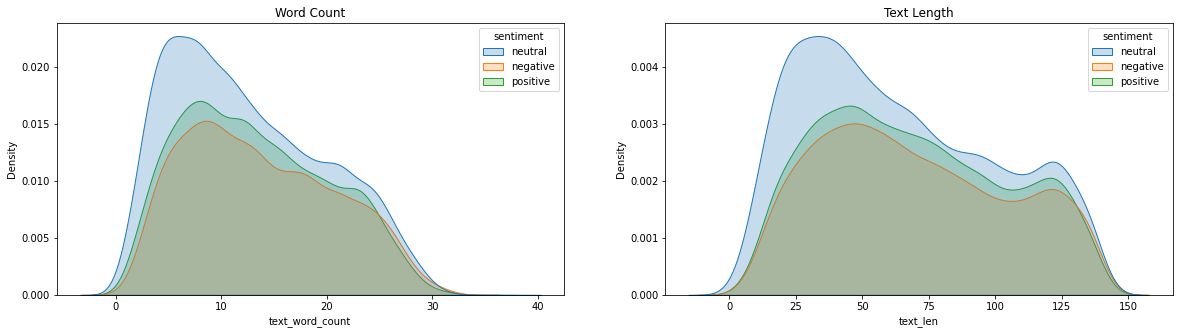

In [12]:

fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.kdeplot(all_df['text_word_count'], hue=all_df['sentiment'], color="r", fill=True,  ax=axes[0])
axes[0].title.set_text('Word Count')
sns.kdeplot(all_df['text_len'], hue=all_df['sentiment'], color="r", fill=True, ax=axes[1])
axes[1].title.set_text('Text Length')


**Tweet Length** -  It is shown here neutral tweets are longet than positive/negatives, and that positive tweets are a bit longer than negatives.
The distribution of the number of tweets to word count seems similar across all sentiments.



### Text vs Selected Text

I want to explore how many selected words we have compared to the original word count.

When using keyword extraction we want to have the most important words, and not many words, since we want to summarize the text to few words.
It is important to us to understand if the dataset tagging is good and the selected text contains small amount of words

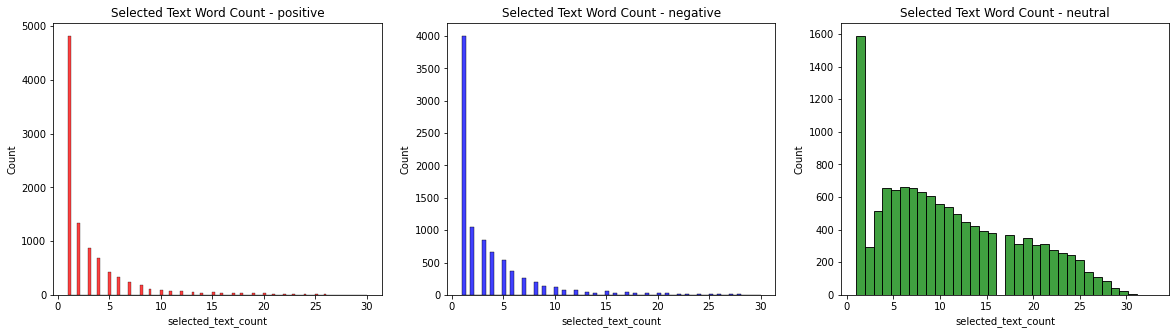

In [13]:
all_df['selected_text_count'] = all_df['selected_text'].apply(lambda x: len(str(x).split()))
all_df['selected_text_len'] = all_df['selected_text'].apply(lambda x: len(str(x)))

fig, axes = plt.subplots(1, 3, figsize=(20,5))
sentiments = ['positive','negative', 'neutral']
colors = ['r','b', 'g']
for i in range(0,3):
  sns.histplot(all_df['selected_text_count'].where(all_df['sentiment']==sentiments[i]).dropna(), color=colors[i], ax=axes[i])
  axes[i].title.set_text(f'Selected Text Word Count - {sentiments[i]}')

This is not as we expected. It seems for positive & Negative tweets most of the selected text is 2-5 words.
However, for the Neutral tweets - we have long selected text, which is suspicious. 
Examine the similarity between those tweets and their selected text can help us understand. I use jaccard similarity for this, as the score in the kaggle challenge.

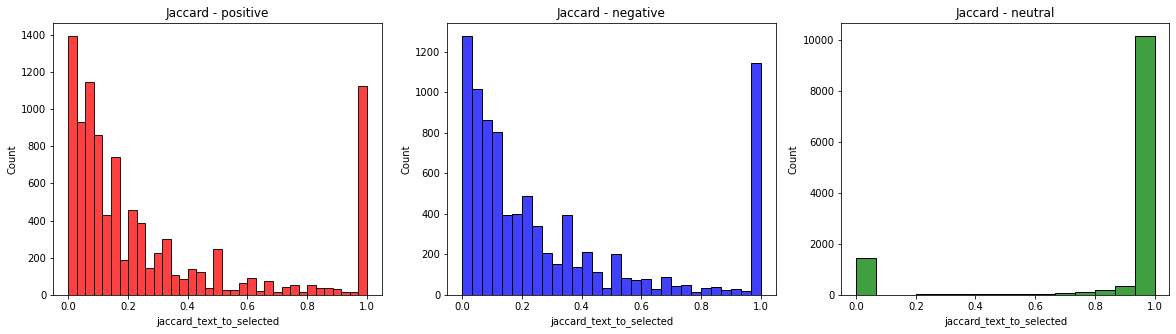

In [14]:
def jaccard(str1, str2):
    set1 = set(str(str1).lower().split())
    set2 = set(str(str2).lower().split())
    intersection = len(set1.intersection(set2))
    set1.update(set2)
    union = len(set1)
    return float(intersection)/ union

all_df['jaccard_text_to_selected'] = all_df.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)

# plot this 
fig, axes = plt.subplots(1, 3, figsize=(20,5))
for i in range(0,3):
  sns.histplot(all_df['jaccard_text_to_selected'].where(all_df['sentiment']==sentiments[i]).dropna(), color=colors[i], ax=axes[i])
  axes[i].title.set_text(f'Jaccard - {sentiments[i]}')


**It's a bug, not a feature** 

jaccard score of 1 means we have the same text both for the tweet and the extracted text.

It turns out most of the neutral tweets are the same as the `selected_text` extracted. Unforthantly, seems like a data leak. Searched it in kaggle discussions and other people found that out (and of course, manipulated their models to follow this leak)

If I was part of the competition, the right approach was to return as selected text the whole text for neutral tweets. However, we are on an academic project.

From the EDA we know we have around 12K rows of neutral tweets, out of 31K.
The conclusion - for the prediction & score of the selected text, I **won't use the neutral tweets**.

Another thing we can see here is that positive & negative tweets have around 1000~ tweets each which has a jaccard score of 1 as well.
I want to look at those either.

> comment- I started to explore this issue when I looked over kaggle notebooks, and saw that people got over 0.60 as score with returning most of the words of the tweet as prediction.


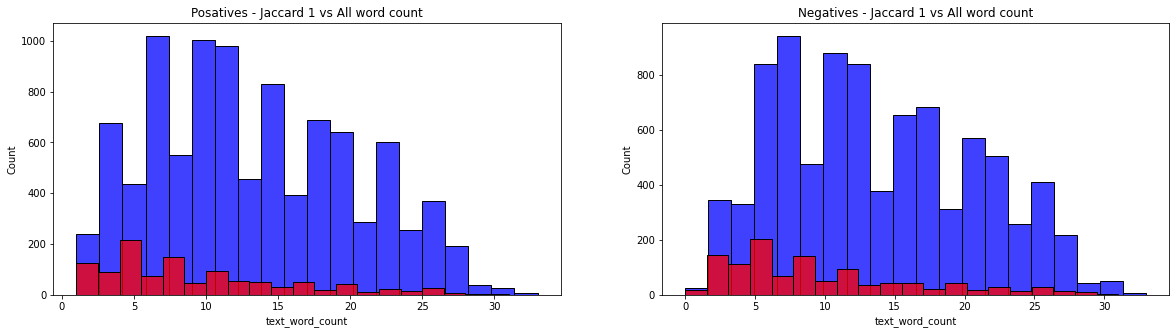

In [15]:
same_selected_df = all_df.where((all_df['sentiment']!='neutral' ) & ( (all_df['jaccard_text_to_selected']==1 ))).dropna()

# plot this 
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(all_df['text_word_count'].where(all_df['sentiment']=='positive').dropna(), color="b", ax=axes[0], bins=20)
sns.histplot(same_selected_df['text_word_count'].where(all_df['sentiment']=='positive').dropna(), color="r", ax=axes[0],bins=20)
axes[0].title.set_text('Posatives - Jaccard 1 vs All word count')

sns.histplot(all_df['text_word_count'].where(all_df['sentiment']=='negative').dropna(), color="b", ax=axes[1],  bins=20)
sns.histplot(same_selected_df['text_word_count'].where(all_df['sentiment']=='negative').dropna(), color="r", ax=axes[1], bins=20)
axes[1].title.set_text('Negatives - Jaccard 1 vs All word count')


I thought that maybe short tweets have the same selected text as the tweet itself, but from the graph, it doesn't seem to be in this way.

Our main finding is the neutral tweets, which seem to be not good for our goal to extract main words.

This made me think - do we want our selected text to be within a certain **limit** of word count?
Maybe, even this is not a part of the kaggle competition, we want to enforce a limit? Is this limit supposed to be static, or this limit supposed to change with the text size?
When I'll explore the models result, I'll look over about the number of words in selected text prediction as well.

Another conclusion - Datasets are not tagged well sometimes. We need to check the tagging to unserstand hoe reliable it is, and many time we need to work with datasets that have tagging problems.

### Onehot Feature & PCA

Feature Extraction: In this method, we create new features, and these features are not present in our original feature set. These features are not interpretable.
The idea - every word in the tweet can become a feature. Each of the categorical parameters (words) will prepare as a separate column. The feature possible values are 1/0 - 1 if the word appears in the tweet and 0 otherwise. This means we can convert our words to numerical form features.
After adding the words feature, I'll use Principal component analysis (PCA) to visualize the data. PCA is the process of computing the principal components and using them to perform a change of basis on the data. After taking the top 1000 used words in the tweets, we can't visualize 1000 features. With dimensionality reduction, it becomes easier to visualize the data when reduced to very low dimensions such as 2D or 3D. I want to visualise our tweets, understanding if our tweets are clustered by sentiment - are positive/negative/neutrals tweets will be gathered as a group?
For other scenarios, it can be helpful to reduce computation power as well.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

# take the top 1000 words as features
def get_top_by_key(dict1, top_num=1000):
  top_dict = dict(sorted(dict1.items(), key=lambda item: item[1], reverse=True)[:top_num])
  top_dict_non_stop={}
  for k, v in top_dict.items(): 
    if k not in stop_words:
      top_dict_non_stop[k]=v
  return top_dict_non_stop

# create the word list
all_df['text_word_list'] = all_df['cleaned_text'].apply(lambda x: str(x).lower().split())
all_words= word_count(all_df['text_word_list'])
all_top = get_top_by_key(all_words)

# Add columns as featurs and run PCA 
cv = CountVectorizer(vocabulary=all_top.keys())
sparse = cv.fit_transform(all_df['cleaned_text'].dropna())
onehot_df = pd.DataFrame.sparse.from_spmatrix(sparse)
features = list(onehot_df.columns)
x = onehot_df.loc[:, features].values
y = all_df.loc[:,'sentiment'].values
pca = PCA(n_components=2)
p_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = p_components , columns = [0,1])
principal_df['sentiment']=pd.Series(y)

# visualize 2D
fig = px.scatter( principal_df, x=0, y=1, color=principal_df["sentiment"])
fig.show()


In [17]:
# visualize 3D
pca = PCA(n_components=3)
p_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = p_components , columns = [0,1,2])
principal_df['sentiment']=pd.Series(y)
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    p_components, x=0, y=1, z=2, color=principal_df['sentiment'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

PCA Results -


*   I've tried to use both 2 and 3 components. 

*   We don't see  "clusters", the clusters are  much more-overlay each other, making them indistinguishable. Our low variance also verifies that most of our data is similar.

* We can observe that positive tweets are more "scatarred" than negative and neutral, and the most distinguished, but that is a minority of the tweets. 

This is a disappointment since I was hoping to see here pretty clusters of negative/positive/neutral tweets.

From reading, there are possible options to PCA not to work well.

PCA cannot be used for sparse data - **Our data is very sparsed! The most popular word appears 2401 times, when we have 372168 rows**. 
That is why I also tried to use SVD which in another method to deminsions reduction but the results where similar.

There are more scenarios where PCA isn't working well-  If features are completely uncorrelated, the lower dimensional representation obtained using PCA would not preserve much of the variance in the original data and hence would be useless , PCA assumes that the principal components are orthogonal.

Or- the tweets are really similar, and our models will need to work hard.

# Modeling

## Classification


Using Classification algorithems to classify tweets sentiment, which is a classic sentiment analysis problem.
The libraries we'll use are NLTK which is the main NLP library, and sklearn which implements many Machine Learning models.

### NLTK Pre-trained Model 

With NLTK pre-trained model, we can just predict the sentiment, without training. It uses VADER-Sentiment-Analysis, which is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## NLTK SentimentIntensityAnalyzer - Pre-trained Model
sia = SentimentIntensityAnalyzer()
sentiment_dict = {
    "neu" : "neutral",
    "pos" : "positive",
    "neg" : "negative"
}
   
def get_sentiment(text):
  score_dict = sia.polarity_scores(text)
  score_dict.pop('compound')
  max_key = max(score_dict, key=score_dict.get)
  return sentiment_dict[max_key]

test_df['predicted'] = test_df['text'].apply(get_sentiment)
true_count = len(test_df[test_df['predicted'] ==test_df['sentiment']])
all_count = len(test_df)
print (f"NLTK Pre-trained Model Accuracy is: {true_count/all_count}")

NLTK Pre-trained Model Accuracy is: 0.48811544991511036


This basic method gave us ~49% of accuracy. 

Even though this model is for social media data, it had been trained on different kind of data then ours, and we can guess that if we'll train the model on our tweet data, we could probably get better results.


### Sklearn - Naive Bayes, Logistic Regression, SGD Classifier

For better classification results, we want to train the models over our data.
The models I've chosen to examine:

1. **Naive Bayes classifiers - Multinomial & Bernoulli** - Naive Bayes classifiers are a family of simple "probabilistic classifiers" ,the name naive is used because it assumes the features that go into the model is independent of each other. Typical applications include filtering spam, classifying documents and sentiment prediction- our case!

2. **Logistic regression** - Logistic regression is named for the function used at the core of the method, the logistic function. Logistic regression, by default, is limited to two-class classification problems. Some extensions like one-vs-rest (which sklearn library implements) can allow logistic regression to be used for multi-class classification problems.


3. **Stochastic gradient descent (SGD)** - An iterative method for optimizing an objective function with suitable smoothness properties. The gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule.

**Feature extraction** - For all the models, we use ```CountVectorizer``` to convert the tweets to a matrix, which implements both tokenization and occurrence.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

# train  with sklearn models - preparation
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True, tokenizer = token.tokenize)
X_train_series , X_test_series = train_df['text'], test_df['text']
Y_train, Y_test = train_df['sentiment'], test_df['sentiment']
X_train= cv.fit_transform(X_train_series)
X_test= cv.transform(X_test_series)

# run models, predict
models = [MultinomialNB(), BernoulliNB(), LogisticRegression(), SGDClassifier()]
predicted_df = test_df[['text', 'sentiment']]

for model in models:
  clf = model.fit(X_train, Y_train)
  predicted = clf.predict(X_test)
  predicted_df[f'predicted_{type(model).__name__}'] = pd.Series(predicted)
  print(f"{type(model).__name__}:\n{metrics.classification_report(Y_test, predicted)}")

MultinomialNB:
              precision    recall  f1-score   support

    negative       0.68      0.60      0.64      1001
     neutral       0.59      0.69      0.64      1430
    positive       0.74      0.66      0.70      1103

    accuracy                           0.66      3534
   macro avg       0.67      0.65      0.66      3534
weighted avg       0.66      0.66      0.66      3534

BernoulliNB:
              precision    recall  f1-score   support

    negative       0.71      0.48      0.57      1001
     neutral       0.56      0.79      0.66      1430
    positive       0.78      0.60      0.68      1103

    accuracy                           0.64      3534
   macro avg       0.69      0.62      0.64      3534
weighted avg       0.67      0.64      0.64      3534

LogisticRegression:
              precision    recall  f1-score   support

    negative       0.69      0.64      0.66      1001
     neutral       0.63      0.71      0.67      1430
    positive       0.79    

We can see those models gave us a better result than the pre-trained model, as expected. Naive Bayes methods gave us 64-66% of accuracy. Overall, **the best classification results are with the SDG classifier**, with 70% accuracy, and logistic regression as a close second with 69%.


Another observation we can see is that in all models, neutral class is with the lowest precision, meaning the models predict positive/negative tweets as  neutral
. This makes sense since in the pos/neg tweets we can recognize tweets that aren't "extremely negative" or "extremely positive". On the other hand, in the recall, it observed that the negative tweets are with the lowest score, which means our models tend to classify negative tweets, even if they are not negative.

I want to look at the predicted dataframe and see where our models are having problems recognizing the right sentiment and why.
The "biggest" mistake our model can do is to predict negative tweets as positive, and the positive as negative. How much "big" mistakes our best model, SDG classifier, did?

In [ ]:
pos_as_neg_df = predicted_df.where((predicted_df['sentiment'] == 'positive') & (predicted_df['predicted_SGDClassifier'] == 'negative')).dropna()
neg_as_pos_df = predicted_df.where((predicted_df['sentiment'] == 'negative') & (predicted_df['predicted_SGDClassifier'] == 'positive')).dropna()
print (f"total: {predicted_df.shape[0]}\npos predicted as neg: {pos_as_neg_df.shape[0]}\nneg predicted as pos: {neg_as_pos_df.shape[0]}")

total: 3534
pos predicted as neg: 49
neg predicted as pos: 40


2.5%~ of the tweets fell to this statistic. I think this is a good number.

I want to look at those mistakes and others, to understand why our models got the wrong predictions to tweets.

In [ ]:
print(predicted_df.iloc[213,0])
predicted_df.iloc[213,1:]

misses my Mom today. She was my Best Friend and even though she has been gone several yrs I still miss her dearly. Happy Mother`s Day


sentiment                       positive
predicted_MultinomialNB         positive
predicted_BernoulliNB           positive
predicted_LogisticRegression    negative
predicted_SGDClassifier         negative
Name: 213, dtype: object

This text is tagged as positive, even though in my opnion it was supposed to be negative - it describes missing to a mother that passed away. This seems to be a incorrect tag. The Naive Bayes models predicted this tweet as pos and Logistic Regression and SGD predicted this tweet as neg.

In [ ]:
print(predicted_df.iloc[543,0])
predicted_df.iloc[543,1:]

Went on a short flight around the Geelong waterfront.  Surprised at how well I handled it, as I`m still exhausted from last weeks meetup


sentiment                       positive
predicted_MultinomialNB          neutral
predicted_BernoulliNB            neutral
predicted_LogisticRegression    negative
predicted_SGDClassifier         negative
Name: 543, dtype: object

This tweet is tagged as positive. Our Naive Bayes model predicted this tweet as neutral and Logistic Regression and SGD predicted this tweet as neg. In contrast to the previous tweet, I think it is positive as it is tagged.

However, analyzing this tweet it says "the flight was good although I thought it won't be", since the author is exhausted. That is why we can understand the neutral and negative predictions as well. Here is another example of to similar tweet:

In [ ]:
predicted_df.iloc[2696,0]

'finally  a beautiful  sunny day in atlanta  too bad i m stuck inside working   '

Before looking at the tagging and the prediction, this tweet is similar to the previous one since it has 2 sections - the first is positive `finally  a beautiful  sunny day in atlanta`, and the second is negative `too bad i m stuck inside working`. In this tweet, the second part is dominant since the author can't enjoy this beautiful day. What about the tag and the predictions for this tag?

In [ ]:
predicted_df.iloc[2696,1:]

sentiment                        neutral
predicted_MultinomialNB          neutral
predicted_BernoulliNB            neutral
predicted_LogisticRegression     neutral
predicted_SGDClassifier         negative
Name: 2696, dtype: object

All the models except the SGD predict this tweet as neutral, and the tag is neutral as well. The SGD model and I agree on this tweet this negative.

A conclusion from the tweets I've examined is that tagging a sentiment to a tweet is not black or white. I can think a tweet is positive, while it might sound neutral to another person. 

Since we are handling tweets, the writers are not writing experts and their message be read not as they meant. Also, since we have a "neutral" class this classification is harder.

Furthermore, it might be the tagging work isn't good enough, as we saw in the EDA section for the selected text to neutral tweets. This is a problem models in the real world have as well, and data often has low quality labels.

I have had an unsuccessful try to enhance the classification models with the results from all of them together. After predicting the four models I used the following logic - 
count score for each tweet and sentiment combination
For each row, predict the sentiment with the highest score
If there is a tie, take SGD prediction.
I thought this way would make me achieve better results, but I got around 65%~ accuracy, in contrast to the theory of the determining majority.

## Tweet Sentiment - Phrases Extraction
After running classification algorithms, the challenge is to find what words in tweets support positive/negative/neutral sentiment. 

As a result of our EDA analysis, I won't predict the neutral tweets. In the kaggle competition, people that understand this bug used it in their favour, and we can imply our results will be lower than the kaggle's competitors. 

### First try - Word Count Naive Approach



The idea - Similar to the "Word Cloud" from EDA section, I want to create a bucket of words for each sentiment. Statistic calculation, similar to tf–idf, intended to reflect how important a word is in a tweet - and score it by the word sentiment.

When I have the bucket of words by sentiments, I can take the most "positive words" with the following flow -

```
1.   other_words <- get top neutral & negative words
2.   positives <- all_positive_words - other_words 
3.   top_positives <- positives[:1000]
```

Each top_positives has the words as a key and the number of occurrences as a value. Of course, the same flow is done for negative words.

When I have this, for each tweet, I am creating all words combinations (Power set). By the tweet sentiment, I can create a score- for each combination, we give a score by the word's value (appearing times). If the words aren't appearing in the sentiment top words dictionary, I reduce the score by a weight.

Finally - The combination with the best score is chosen.

Comment - I thought about the tf-idf solution, and after that found this notebook https://www.kaggle.com/nkoprowicz/a-simple-solution-using-only-word-counts that has a similar approach. It helped me with how to take the "tf-idf"  idea to code.

In [ ]:
# preperation -  naive pproach
def get_top_by_key(dict1, top_num=1000):
  top_dict = dict(sorted(dict1.items(), key=lambda item: item[1], reverse=True)[:top_num])
  return top_dict

def dict_sub_values(main_dict: dict, sub_dict):
  subed_dict = {key: main_dict[key] - sub_dict.get(key, 0) for key in main_dict}
  return subed_dict


train_positives = train_df.where(train_df['sentiment'] == 'positive').dropna()
train_negatives = train_df.where(train_df['sentiment'] == 'negative').dropna()
train_neutrals = train_df.where(train_df['sentiment'] == 'neutral').dropna()


tain_word_list_dict = {
    'Positives' : word_count(train_positives['word_list']),
    'Negatives' : word_count(train_negatives['word_list']),
    'Neutrals' : word_count(train_neutrals['word_list'])
}

top_words_dict = {}
for sentiment, word_list in tain_word_list_dict.items():
  top_words_dict[sentiment] = get_top_by_key(word_list)


# substract top words from other types
tain_word_list_dict['Negatives'] = dict_sub_values(tain_word_list_dict['Negatives'], top_words_dict['Neutrals'])
tain_word_list_dict['Negatives'] = dict_sub_values(tain_word_list_dict['Negatives'], top_words_dict['Positives'])
tain_word_list_dict['Positives'] = dict_sub_values(tain_word_list_dict['Positives'], top_words_dict['Neutrals'])
tain_word_list_dict['Positives'] = dict_sub_values(tain_word_list_dict['Positives'], top_words_dict['Negatives'])

# finally, work with top of the results
top_dicts = {
    'positive' : get_top_by_key(tain_word_list_dict['Positives']),
    'negative' : get_top_by_key(tain_word_list_dict['Negatives'])
}

In [ ]:
# The naive model - prediction function
def native_prediction(cleaned_text, sentiment, weight= 1):
    words = cleaned_text.split()  
    max_score = 0
    selected_words = []
    
    if(sentiment =='neutral'):
        return cleaned_text # the bug we found
    dict_to_use = top_dicts[sentiment]

    combs = []
    for i in range(len(words)):
       for j in range(i,len(words)):
         combs.append(words[i:j+1])
  
    for comb in combs:
        sum = 0 
        for word in comb:
          if word.lower() in dict_to_use.keys():
            sum += dict_to_use.get(word.lower())
          else:
            sum -= weight
            weight += 1

        if(sum > max_score):
          max_score = sum
          selected_words = comb
    
    # we found nothing - return first words 
    if(max_score == 0):
        selected_words = words[:5]
    
    return ' '.join(selected_words)

Testing the results - I'll look over all dataset and over only positive & negative tweets.

Since I've used generate_selected_text in clean text, I am comparing clean text. 

We can use the "dirty" instead, but our words dictionary will be less efficient. 

In [ ]:
val_df['predicted'] = val_df.apply(lambda x: native_prediction(x['cleaned_text'], x['sentiment']), axis = 1)

def jaccard(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    if (len(a) + len(b) - len(c)) == 0 :
      return 0
    else:
      return float(len(c)) / (len(a) + len(b) - len(c))

def jaccard_cleaned(str1, str2):
    a = set(clean_text(str1).split())
    b = set(clean_text(str2).split())
    c = a.intersection(b)
    if (len(a) + len(b) - len(c)) == 0 :
      return 0
    else:
      return float(len(c)) / (len(a) + len(b) - len(c))

val_df['naive_jaccard_claened'] = val_df.apply(lambda x: jaccard_cleaned(x['selected_text'], x['predicted']), axis = 1)
val_df['naive_jaccard'] = val_df.apply(lambda x: jaccard(x['selected_text'], x['predicted']), axis = 1)

# all data - including neutral
jaccard_all = round(np.mean(val_df['naive_jaccard']),5) 
jaccard_cleaned_all = round(np.mean(val_df['naive_jaccard_claened']),5) 
print(f'Jaccard score - All data: uncleaned: {jaccard_all}, cleaned: {jaccard_cleaned_all}')

# real data
non_neutral = val_df.where(val_df['sentiment'] != 'neutral').dropna()
jaccard_all = round(np.mean(non_neutral['naive_jaccard']),5) 
jaccard_cleaned_all = round(np.mean(non_neutral['naive_jaccard_claened']),5) 
print(f'Jaccard score - Real data: uncleaned: {jaccard_all}, cleaned: {jaccard_cleaned_all}')



Jaccard score - All data: uncleaned: 0.37167, cleaned: 0.64508
Jaccard score - Real data: uncleaned: 0.25586, cleaned: 0.41964


**Results**

Overall data isn't reliable, because of the neutral bug we found. 
The only reason I've tested score overall tweets is to know where I stand compared to the competition results, since neutral tweets are much easier to extract words from. the best score is 0.73615

Kaggle's score is supposed to be similar to the `jaccard` function. `jaccard_cleaned` is for understanding how close we are if we are looking over letters and numbers only.

over letters and numbers only.

We can see it has that the **score for cleaned data is much better**.
It's hard to deal with the fact we have in our predictions not only words but signs and punctuations. 

This is why this model isn't good enough - it can't handle the signs in the text, since it takes the "most common" word, while the challenge requires to predicts those as well, since it in the "selected_text".

In tweets, words can be written differently - people use "leet" speak (replace  Latinate letters with symbols), have typos, and much more Twitter symptoms.
So, we'll need a model that can predict with the symbols in the text.

### Netural Networks - roBERTa model




While reading about NLP, it was hard to miss the latest innovations of NLP on 2018 - Transformers, and 2019 BERT — Bidirectional Encoder Representations from Transformers. 

Google **BERT** is a pre-training method for natural language understanding that performs various NLP tasks better than ever before.
BERT works in two steps, First, it uses a large amount of unlabeled data to learn a language representation in an unsupervised fashion called pre-training. Then, the pre-trained model can be fine-tuned in a supervised fashion using a small amount of labeled trained data to perform various supervised tasks. 

**RoBERTa** Introduced at Facebook, Robustly optimized BERT approach RoBERTa, is a retraining of BERT with improved training methodology.
To improve the training procedure, RoBERTa removes the Next Sentence Prediction (NSP) task from BERT’s pre-training and introduces dynamic masking so that the masked token changes during the training epochs. 

After reading and examine notebooks on kaggle, I've understood the best result can be with BERT based model. I decided to go with **roBERTa model**.

In [ ]:
! pip install transformers
from transformers import RobertaTokenizer, TFRobertaModel
import tensorflow as tf
tf.get_logger().setLevel('WARNING')
from keras.preprocessing.sequence import pad_sequences
import re
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
import os
import datetime

     |████████████████████████████████| 2.6 MB 3.9 MB/s 
     |████████████████████████████████| 895 kB 23.0 MB/s 
     |████████████████████████████████| 3.3 MB 42.9 MB/s 
     |████████████████████████████████| 636 kB 40.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/test.csv")

# filter neutral tweets
train_data = train_data.where(train_data['sentiment'] != 'neutral').dropna() 
train, val = train_test_split(train_data, test_size=0.2, stratify=train_data['sentiment'])

# use roBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_text_encoding = tokenizer(list(train['text']))
val_text_encoding = tokenizer(list(val['text']))

train_ids_ts = pad_sequences(train_text_encoding['input_ids'],padding='post',maxlen=96,value=1)
val_ids_ts = pad_sequences(val_text_encoding['input_ids'],padding='post',maxlen=96,value=1)
train_attention_masks = pad_sequences(train_text_encoding['attention_mask'] ,padding='post',maxlen=96)
val_attention_masks = pad_sequences(val_text_encoding['attention_mask'] ,padding='post',maxlen=96)

# selected text to binary represntation
def binary_labels(row):
    all_words = list(row['text'].split())
    label = [0]*len(all_words) 
    selected_words = row['selected_text'].split()

    for word_idx in range(0, len(all_words)):
        if all_words[word_idx] in selected_words:
            label[word_idx] = 1
    return label


train['labels'] = train.apply(binary_labels, axis=1)
val['labels'] = val.apply(binary_labels, axis=1)

y_pad_train = pad_sequences(train['labels'], maxlen=96, padding='post', value=2)
y_pad_val = pad_sequences(val['labels'], maxlen=96, padding='post', value=2)


In [ ]:
def get_start_pos(y_pad_seq):
  start_pos = np.zeros((len(y_pad_seq), 96))
  for i in range(y_pad_seq.shape[0]):
    for j in range(96):
        if (y_pad_seq[i][j] == 1):
            start_pos[i][j] = 1
            break
  return start_pos

def get_end_pos(y_pad_seq):
  end_pos = np.zeros((len(y_pad_seq), 96))
  for i in range(y_pad_seq.shape[0]):
    for j in range(95, -1, -1):
        if (y_pad_seq[i][j] == 1):
            end_pos[i][j] = 1
            break
  return end_pos

start_train = get_start_pos(y_pad_train)
end_train = get_end_pos(y_pad_train)
start_val = get_start_pos(y_pad_val)
end_val = get_end_pos(y_pad_val)

In [ ]:
# https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143281

@tf.autograph.experimental.do_not_convert
def build_model():
    MAX_LEN = 96
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    bert_model = TFRobertaModel.from_pretrained('roberta-base')
    roberta = bert_model(ids, attention_mask=att)

    drop1 = tf.keras.layers.Dropout(0.1)(roberta[0])
    conv1 = tf.keras.layers.Conv1D(1, 1)(drop1)
    flat1 = tf.keras.layers.Flatten()(conv1)
    out1 = tf.keras.layers.Activation('softmax')(flat1)

    drop2 = tf.keras.layers.Dropout(0.1)(roberta[0])
    conv2 = tf.keras.layers.Conv1D(1, 1)(drop2)
    flat2 = tf.keras.layers.Flatten()(conv2)
    out2 = tf.keras.layers.Activation('softmax')(flat2)

    model = tf.keras.models.Model(inputs=[ids, att, ], outputs=[out1, out2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

model=build_model()
model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model_1 (TFRobertaMo TFBaseModelOutputWit 124645632   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_76 (Dropout)            (None, 96, 768)      0           tf_roberta_model_1[0][0]   

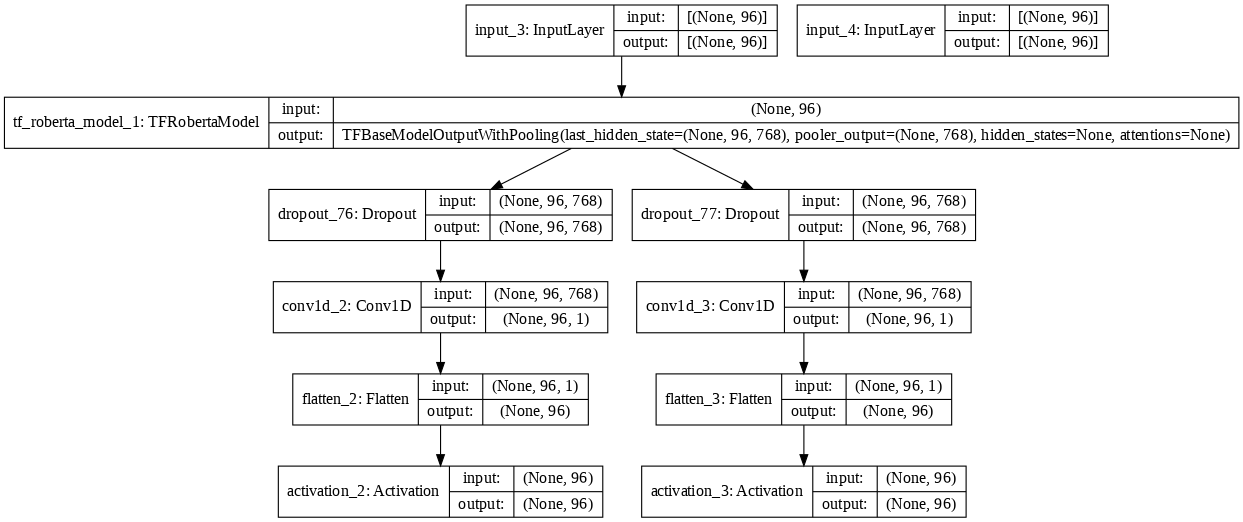

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)

In [ ]:
# time with GPU - 14m
model.fit([train_ids_ts ,train_attention_masks],[start_train,end_train],
                validation_data = ([val_ids_ts, val_attention_masks], [start_val,end_val]),
                epochs=3, batch_size=40, verbose=1)

Epoch 1/3
328/328 [==============================] - 190s 519ms/step - loss: 4.5411 - activation_2_loss: 2.1223 - activation_3_loss: 2.4189 - activation_2_accuracy: 0.3344 - activation_3_accuracy: 0.2066 - val_loss: 3.7015 - val_activation_2_loss: 1.7453 - val_activation_3_loss: 1.9562 - val_activation_2_accuracy: 0.4122 - val_activation_3_accuracy: 0.3489
Epoch 2/3
328/328 [==============================] - 166s 508ms/step - loss: 3.5643 - activation_2_loss: 1.6878 - activation_3_loss: 1.8765 - activation_2_accuracy: 0.4104 - activation_3_accuracy: 0.3542 - val_loss: 3.1928 - val_activation_2_loss: 1.5425 - val_activation_3_loss: 1.6503 - val_activation_2_accuracy: 0.4488 - val_activation_3_accuracy: 0.4357
Epoch 3/3
328/328 [==============================] - 166s 507ms/step - loss: 3.1496 - activation_2_loss: 1.5235 - activation_3_loss: 1.6261 - activation_2_accuracy: 0.4603 - activation_3_accuracy: 0.4332 - val_loss: 3.1512 - val_activation_2_loss: 1.5043 - val_activation_3_loss: 1.

In [ ]:
predictions = model.predict([val_ids_ts,val_attention_masks])

In [ ]:
starts=[]
ends=[]
for i in range(val.shape[0]):
  starts.append(np.argmax(predictions[0][i]))
  ends.append(np.argmax(predictions[1][i]))
val['first'] = starts
val['last'] = ends


In [ ]:
def pred(df):
  text_lst=list(df['text'].split())
  length=len(text_lst)  
  a=int(df['first'])  
  b=int(df['last'])  
  res=''  
  if (a > b):
    res += df['text']
  elif (b >= length):
    b = min(b,length)
    for i in range(a,b):
      res += str(text_lst[i])+' '
  else:
    for i in range(a,b+1):
      res += str(text_lst[i])+' '       
  return res.strip() 
val['pred']=val.apply(pred,axis=1)
val.head(5)

textID  ...                     pred
7586   a6ef1a8e11  ...            I am so bored
3395   b805965f64  ...                  amazing
6796   aee80f7dd0  ...               ooooh tooo
24695  b9a0286741  ...  The photos are AMAZING!
10366  7ed19d9afd  ...                    Power

[5 rows x 8 columns]

In [ ]:
def jaccard(str1, str2):
  a = set(str(str1).lower().split())       
  b = set(str(str2).lower().split())      
  c = a.intersection(b)
  if (len(a) + len(b) - len(c)) == 0:
    return 0 
  return float(len(c)) / (len(a) + len(b) - len(c))

def jaccard_cleaned(str1, str2):
    a = set(clean_text(str1).split())
    b = set(clean_text(str2).split())
    c = a.intersection(b)
    if (len(a) + len(b) - len(c)) == 0:
      return 0 
    return float(len(c)) / (len(a) + len(b) - len(c))

val['jaccard']= val.apply(lambda x: jaccard(x['selected_text'], x['pred']), axis = 1)
val['jaccard_cleaned']= val.apply(lambda x: jaccard_cleaned(x['selected_text'], x['pred']), axis = 1)
print (f"jaccard: {val['jaccard'].mean()}")
print (f"jaccard_cleaned: {val['jaccard_cleaned'].mean()}")

jaccard: 0.47041935597254636
jaccard_cleaned: 0.4826290814307605


We can see that not like the work count model, we don't have here much diffrence betweent the cleaned score method to the uncleaned score method.
The results - **47% of jaccard similirity** between the selected text and the predicted, for both negative and poritive tweets.
This is an improvement to the word count approach, when we got around 25% of similarity.

In [ ]:
print ("neg: " + str(val.where(val['sentiment']=='negative').dropna()['jaccard'].mean()))
print ("pos: " + str(val.where(val['sentiment']=='positive').dropna()['jaccard'].mean()))

neg: 0.4753725484609209
pos: 0.4659306154297931


The model predicted pos & neg tweets with similar prediction score.


#### Model Predictions Analysis

I want to look over the worst predictions, and try to understand what happened. 

First, Look as the **negative tweets that have 0 jaccard score**, and try to understand why the prediction wasn't right at all.

In [ ]:
pd.options.display.max_colwidth = 200
review_df = val[['text', 'selected_text','sentiment','pred','jaccard','jaccard_cleaned']]
neg_wrong_df = review_df.where((review_df['jaccard']==0) & (review_df['sentiment'] == 'negative')).dropna()

In [ ]:
neg_wrong_df

text  ... jaccard_cleaned
18173                                                                                              _1   is leavin bc of racists *starts cryin*  ...        0.125000
7344                                                                                          dammm..i thought i was on to something  lollllll  ...        0.125000
1297                                                     always excited for a new chapter in my life. just didnt expect it to be so emotional.  ...        0.000000
14680                                            used is definitely cheaper... may have to get later ones that way... but new is ok for now...  ...        0.250000
9435                                                                                                 shud up! lol my device thing doesn`t work  ...        0.000000
...                                                                                                                                        ...  ...             ...
25877                                                                    yeah, that does sound a bit bad man... i got **** exam week this week  ...        0.000000
15251  is watching big brothes big quiz    ,       rather tiredd    , but downloading a dvd so have to wait till finished till i can go to bed  ...        0.000000
11685                                                                  RIP Omar Edwards - Killed by friendly fire in NYC   http://bit.ly/jrM6v  ...        0.000000
7149                                                    I`m soo sad. It`s just on the edges of the pages, but it`s not gonna come out. *cries*  ...        0.333333
17724                                                                                                    I wanna leave after 2nd period *cryy*  ...        0.142857

[233 rows x 6 columns]

Total of 233 of those tweets.

In [ ]:
neg_wrong_df.loc[[11685]]

text  ... jaccard_cleaned
11685  RIP Omar Edwards - Killed by friendly fire in NYC   http://bit.ly/jrM6v  ...             0.0

[1 rows x 6 columns]

From this example, which got "0" score, it seems both options are reasonable.
If I should select the words that emphasise this tweet and negative sentiment tweet, I would choose both words: RIP & Killed. But since the tagging was only with "Killed", our model got 0 as a score.
But some predictions seem to be deserved the score "0" more than this tweet. For example:

In [ ]:
neg_wrong_df.loc[[2996, 1297, 12941, 5523]]

text  ... jaccard_cleaned
2996   just got back from the ER... i cut myself while trying to cook a nice lunch  3 stiches on my right index finger, talk about ouchie  ...             0.0
1297                                                always excited for a new chapter in my life. just didnt expect it to be so emotional.  ...             0.0
12941                                                Adam Samberg + new moon trailor = good evening. Too bad my cable is off as of friday  ...             0.0
5523                                                                                                  Ahhh, 7 am meetings  thanks Reimer!  ...             0.0

[4 rows x 6 columns]

The common thing for those tweets is that the pred word is positive, even though we are looking for a negative phrase. as for `1297`, I am not so sure it's a neg tweet, but when assuming it is, we need to extract the neg main words. This can be as a result of training both neg & pos together. If we have many tweets (pos/neg) with this symptom - extracting neg words instead of positive or extracting pos words instead of neg, we can consider running two separate models.

Next, Look at the **positive tweets that have 0 Jaccard score**, and try to understand why the prediction wasn't right at all.


In [ ]:
pos_wrong_df = review_df.where((review_df['jaccard']==0) & (review_df['sentiment'] == 'positive')).dropna()
pos_wrong_df

text  ... jaccard_cleaned
3833    'phlegmily green house...' That was clever, but ever sooooooo ...... eeeeewwwwww. [more slow clapping] Get well soon.  ...        0.000000
13004                       _sara I`m sitting in the bus to dublin And listen tokio hotel-reden.And i must laugh.you know why  ...        0.142857
6005                      Good morning to another too late sleeper .  One of my excellent designers is Valerie (see ) picture  ...        0.000000
18213                                Good night all, 15 miles of trails with 7 peeks to climb in the morning, fun times ahead  ...        0.000000
4126                                                                        Happy mother`s day to all the mom`s! Love you mom  ...        0.000000
...                                                                                                                       ...  ...             ...
90                                                                          SWEEEEET - San Fran is awesome!!!!  Love it there  ...        0.000000
12950                                                                      Congratulations...keep us posted on how things go!  ...        0.500000
18627                                                                              #HappyMothersDay to all the moms out there  ...        1.000000
25593                                                                                     fantastic.... pick up a **** for me  ...        1.000000
15044                                                Headin home...Refreshed my mind and soul justa lil bit...Bac to reality.  ...        0.000000

[281 rows x 6 columns]

Total of 281 of those. Let's look at some examples.

In [ ]:
pos_wrong_df.loc[[3363,6377,15774,22415,4126, 7991, 14889, 16269, 7033]]

text  ... jaccard_cleaned
3363                                                                                                goodmorning/night to you too! sleep well  ...             0.5
6377                                                  Passing out  early  after the  river sounds amazing. To my cozy bed  with my cozy dogs  ...             0.0
15774                                                                                          Boredddddd Follower  Shes AMAZING!!  *Broken*  ...             0.5
22415                                                                      Yay! Go wyattt your totally amazing`!`! Im So happy for you.  yay  ...             0.0
4126                                                                                       Happy mother`s day to all the mom`s! Love you mom  ...             0.0
7991                                                         My Dad told me music that has the power to heal the soul. Sure is true of yours  ...             0.0
14889                                                                                                  haha, yeah i meant mall! -winks back-  ...             0.0
16269                                                                    YEHEY SUMMER!!  so exciteeeddd.. balme it on the a-a-a-a-a-alcohol.  ...             0.5
7033   is sipping OJ in the sun in San Pedro at La Soberana again, with sunny smiley Nita...  The garlic tomato paste is delicious! Yummy!!!  ...             0.0

[9 rows x 6 columns]

The common to all of those - our model wasn't so bad with the prediction, and with some tweets, it was even better than the selected text, but the Jaccard score is 0. Why? looking at those tweets, you can analyze - different chosen words that the tagged selected_text, different symbols extraction (in those tweets the jaccard_cleaned is higher). 

But our model also have mistakes that seems less reasonable - 

In [ ]:
pos_wrong_df.loc[[988, 5231, 14652, 10715]]

text  ... jaccard_cleaned
988    nite nite twitts i wish u all a happy sunday i already have my major gift my my 2kids-my bro-n @_agressiva23 n 1 other gift on d way  tyg  ...             0.0
5231                                                                                     ROFLMAO! I feel inspired to go start a huge bonfire now  ...             0.0
14652                               Whew! Moving commercial-sized freezer and cooler a lot more work than I expected. Missing the HTC roundtable  ...             0.0
10715                                           Dow futures up 60 points in over night trading. Looks like May is off to a good start so far  /f  ...             0.0

[4 rows x 6 columns]

Those tweets' prediction is with common conjunctions english words, and not really positive pharses from the tweets.
I am not sure to the reason, but it can related to this words popularity.

Next, even though the jaccard_cleaned wasn't much higher than the jaccard score, let's look at examples when it was-

In [ ]:
review_df.where((review_df['jaccard_cleaned']  > review_df['jaccard'] )).dropna().head(10)

text  ... jaccard_cleaned
18173        _1   is leavin bc of racists *starts cryin*  ...        0.125000
7344    dammm..i thought i was on to something  lollllll  ...        0.125000
22593   omgggggggggg, cant belive it! what had happen...  ...        1.000000
13004  _sara I`m sitting in the bus to dublin And lis...  ...        0.142857
17766   Ohh noo. Joshua im sooo sorry i was out ,im r...  ...        0.333333
14680   used is definitely cheaper... may have to get...  ...        0.250000
11616   haha  I need to get in better shape first.. I...  ...        0.142857
20481   yeah thought it was awesome - glad to see som...  ...        0.058824
10438   haha it`s ok. i really don`t like getting to ...  ...        0.384615
2134   Trying to recover photos after a problem betwe...  ...        0.050000

[10 rows x 6 columns]

We could gain a bit higher score predictions with those results, which got lower jaccard then the	jaccard_cleaned.

Overall, the predictions seem to be great even when the model got a low score, the prediction sometimes expresses the sentiment keyword extraction from the text.

# Conclusions and final words

## Results 
**Classification - Accuracy Results**
* NLTK Pretrained model - 0.49
* Multinomial naive Bayes - 0.66
* Bernoulli naive Bayes - 0.64
* Logistic regression - 0.69
* Stochastic gradient descent (SGD) - 0.70

Classification is an easier problem than phrase extraction, and this is the reason we got higher score results.
For getting better results, I could use grid search methods, to optimize the hyper params of all the models. The models could potentially perform better with different hyper parameters.

**Phrase Extraction**

* Word Count - 0.2558
* roBERTa - 0.4704

**Word Count**
* The reason I wanted to first try the word count approach, is to have a feeling about building a model with my logic.
Since NN models are more of a "black box", with the word count model I can investigate and understand my results. Moreover, I wanted to build a model without much "ML" knowledge.

* Word Count main problem is that since it relies on "common words", I needed to use cleaned text, while the selected text isn't cleaned. 
To improve this model to have a better result with `jaccard` function, we'll need to build a map from the tweet words to the "common words", then running the prediction with that mapping. 

**roBERTa**
* With the roBERTa, I've taken the prediction to the next level, and it's shown in the prediction results.
Our results, comparing to the Kaggle challenge- the best score in the challenge is 0.73615. With training our model with the neutral tweets, I've got around 0.63. Keep in mind Kaggle results can be with neutral manipulation.

* As a data engineer, my first approach was - let's clean the text! I am familiar with data pre-processing flows, and I thought it required cleaning the data before using the model.
I run the models on cleaned data/uncleaned data and the result was that modelling with uncleaned data is better. The reason is when I cleaned the data, I lost data- non-alphanumeric characters, which have meaning and appears in the texts a lot.

* Running the roBERTa model on my local PC with Intel Core i7 didn't end after 3 hours. When running with GPU over colab, it took around 15 minutes, and after I signed up for a subscription with GPU priority it took around 5 minutes.


**General Conclusions**
*  Neutral Tweets - A lesson to the real-world data, where data tagging is far from being perfect. This is the main thing we found out in our EDA, and without this funding, it was much harder to understand the model.


## Self reflection

When starting this project I thought NPL is interesting to investigate.
After a while, I understood this choice was better than I thought and how many state-of-the-art advancements are happening in NLP at such a rapid pace.
I was partly familiar with Word2Vec concept and RNN networks and started reading about it.

When reading, it was hard to miss the latest innovations of NLP on 2018 - Transformers, and 2019 BERT — Bidirectional Encoder Representations from Transformers. 

At first, it was hard to understand what is happening and I've seen too many scary words - "encoder\decoder", "attention", "self-attention", "masking"..
After watching this first lecture - https://www.youtube.com/watch?v=rv6ogBCIoC4 it didn't seem too scary anymore, and I've started with modelling and having fun.
Now, in my summer semester, I have a seminar and my goal dive into these concepts more. 

In my daily work, I am working with researchers a lot and I am happy that I've been given the opportunity to be familiar with the research process, and data science project life cycle. Thank you!